In [3]:
import sys
 
# setting path
sys.path.append('../../data')
from data import *

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn import svm

import pandas as pd
import numpy as np
import datetime

In [4]:
start = datetime.datetime.now()

In [5]:
past_hours = 6
n_steps = past_hours
next_hours = 4
next_steps = next_hours

In [6]:
transformations = [e for n in select_stations for e in ('tmp'+str(n), 'swrad'+str(n), 'lwrad'+str(n), 'wind'+str(n))]
transformations = [(str(i), MinMaxScaler(copy=True), make_column_selector(pattern = e)) for i,e in enumerate(transformations)]
transformations += [(str(len(transformations)),OneHotEncoder(), make_column_selector(pattern = 'hour'))]
transformations += [(str(len(transformations)),OneHotEncoder(), make_column_selector(pattern = 'day'))]
transformations += [(str(len(transformations)),OneHotEncoder(), make_column_selector(pattern = 'month'))]
transformations += [("y",StandardScaler(copy=True), make_column_selector(pattern = 'ERCOT'))]
ct = ColumnTransformer(transformations)

normed_data = pd.DataFrame(ct.fit_transform(load_data))
normed_data

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,0.487742,0.0,0.229848,0.175246,0.515970,0.0,0.236395,0.288098,0.538541,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.861036
1,0.450905,0.0,0.229824,0.200738,0.474372,0.0,0.236392,0.257994,0.503909,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.727637
2,0.414036,0.0,0.194472,0.226748,0.432791,0.0,0.195790,0.229942,0.469412,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.782265
3,0.397926,0.0,0.194472,0.217296,0.426221,0.0,0.195790,0.191008,0.448930,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.941622
4,0.381831,0.0,0.194454,0.213117,0.419720,0.0,0.195790,0.155684,0.428448,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.188049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94909,0.414130,0.0,0.543971,0.151403,0.625292,0.0,0.528028,0.254790,0.471742,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.436792
94910,0.418746,0.0,0.520742,0.164654,0.610454,0.0,0.607941,0.214727,0.453827,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269458
94911,0.417530,0.0,0.520742,0.242358,0.605925,0.0,0.607941,0.168782,0.454671,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.129600
94912,0.416313,0.0,0.520742,0.327699,0.601551,0.0,0.607941,0.123072,0.455516,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005014


In [7]:
dataset = normed_data.values
steps = n_steps+next_steps
time_series =  np.array([dataset[i:i + steps].copy() for i in range(len(dataset) - steps) if load_data.index[i+steps] - load_data.index[i] == datetime.timedelta(hours=steps)])

time_series.shape

(94378, 10, 76)

In [8]:
X = np.array([s.flatten() for s in time_series[:, :n_steps]])
Y = np.array([s for s in time_series[:, n_steps:, -1]])

print(X.shape, Y.shape)

(94378, 456) (94378, 4)


In [9]:
#sizes for test, train, and validation datasets
a = len(time_series)
b = int(0.9*a)
c = int(a-b)//2

In [10]:
X_train,    Y_train =   X[:b],      Y[:b]
X_test,     Y_test  =   X[b+c:],    Y[b+c:]

In [11]:
models = [svm.SVR() for i in range(next_hours)]
for i in range(next_hours): models[i].fit(X_train, Y_train[:,i])

In [16]:
test_predictions = [model.predict(X_test) for model in models]
op_list= [e for s in zip(*test_predictions) for e in s]   #predicted list
ip_list = [e for y in Y_test for e in y]    #actual list

In [17]:
from statistics import mean, stdev

In [18]:
test_labels = pd.DataFrame({'actual':ip_list})
predictions = pd.DataFrame({'predict':op_list})
test_labels['actual'] = ct.named_transformers_['y'].inverse_transform(test_labels)
predictions['predict'] = ct.named_transformers_['y'].inverse_transform(predictions)

error = predictions['predict'] - test_labels['actual']
rerror = 100*(predictions['predict'] - test_labels['actual'])/test_labels['actual']

print('Mean of error in test data:', mean(error))
print('Mean of absolute error in test data:', mean(abs(error)))
print('Root of mean of squared error in test data:', mean(error**2)**0.5)
print('Standard deviation of error in test data:', stdev(error))
print("=============================================================")
print('MPE (%):', mean(rerror))
print('MAPE (%):', mean(abs(rerror)))
print('RMSPE (%):', mean(rerror**2)**0.5)
print('Deviation of error (%):', stdev(rerror))
print("=============================================================")
print('Mean of test data:', mean(test_labels['actual']))
print('Standard deviation of test data:', stdev(test_labels['actual']))
print("Coefficient of determination:",r2_score(test_labels['actual'], predictions['predict']))

Mean of error in test data: -228.71353057775661
Mean of absolute error in test data: 599.0951168604886
Root of mean of squared error in test data: 812.3604384928968
Standard deviation of error in test data: 779.5202336861265
MPE (%): -0.42433583954359594
MAPE (%): 1.2597129908899618
RMSPE (%): 1.6924304172704252
Deviation of error (%): 1.63841448511095
Mean of test data: 47586.94378734902
Standard deviation of test data: 10122.94285891266
Coefficient of determination: 0.9935596870942417


In [15]:
#absolute errors
for threshold in [5,10,50,100,500,1000,1500,2000,3000,4000,5000]:
    accuracy = sum(abs(e) < threshold for e in error)/len(error)*100
    print('accuracy:', accuracy,'% with threshold of', threshold)

accuracy: 0.609239245602882 % with threshold of 5
accuracy: 1.2025852934943844 % with threshold of 10
accuracy: 5.785123966942149 % with threshold of 50
accuracy: 11.888111888111888 % with threshold of 100
accuracy: 54.48188175460903 % with threshold of 500
accuracy: 82.59165077346896 % with threshold of 1000
accuracy: 93.1394363212545 % with threshold of 1500
accuracy: 97.22398813307905 % with threshold of 2000
accuracy: 99.50201313837678 % with threshold of 3000
accuracy: 99.90464081373173 % with threshold of 4000
accuracy: 99.98410680228862 % with threshold of 5000


In [16]:
#relative errors
for threshold in [0.5,1,1.5,2,3,4,5]:
    accuracy = sum(abs(e) < threshold for e in rerror)/len(error)*100
    print('accuracy:', accuracy,'% with threshold of', threshold)

accuracy: 26.98664971392244 % with threshold of 0.5
accuracy: 51.112523839796566 % with threshold of 1
accuracy: 68.76986649713922 % with threshold of 1.5
accuracy: 81.00762873490146 % with threshold of 2
accuracy: 92.98580207671117 % with threshold of 3
accuracy: 97.19220173765628 % with threshold of 4
accuracy: 98.74443738080102 % with threshold of 5


In [13]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 48})

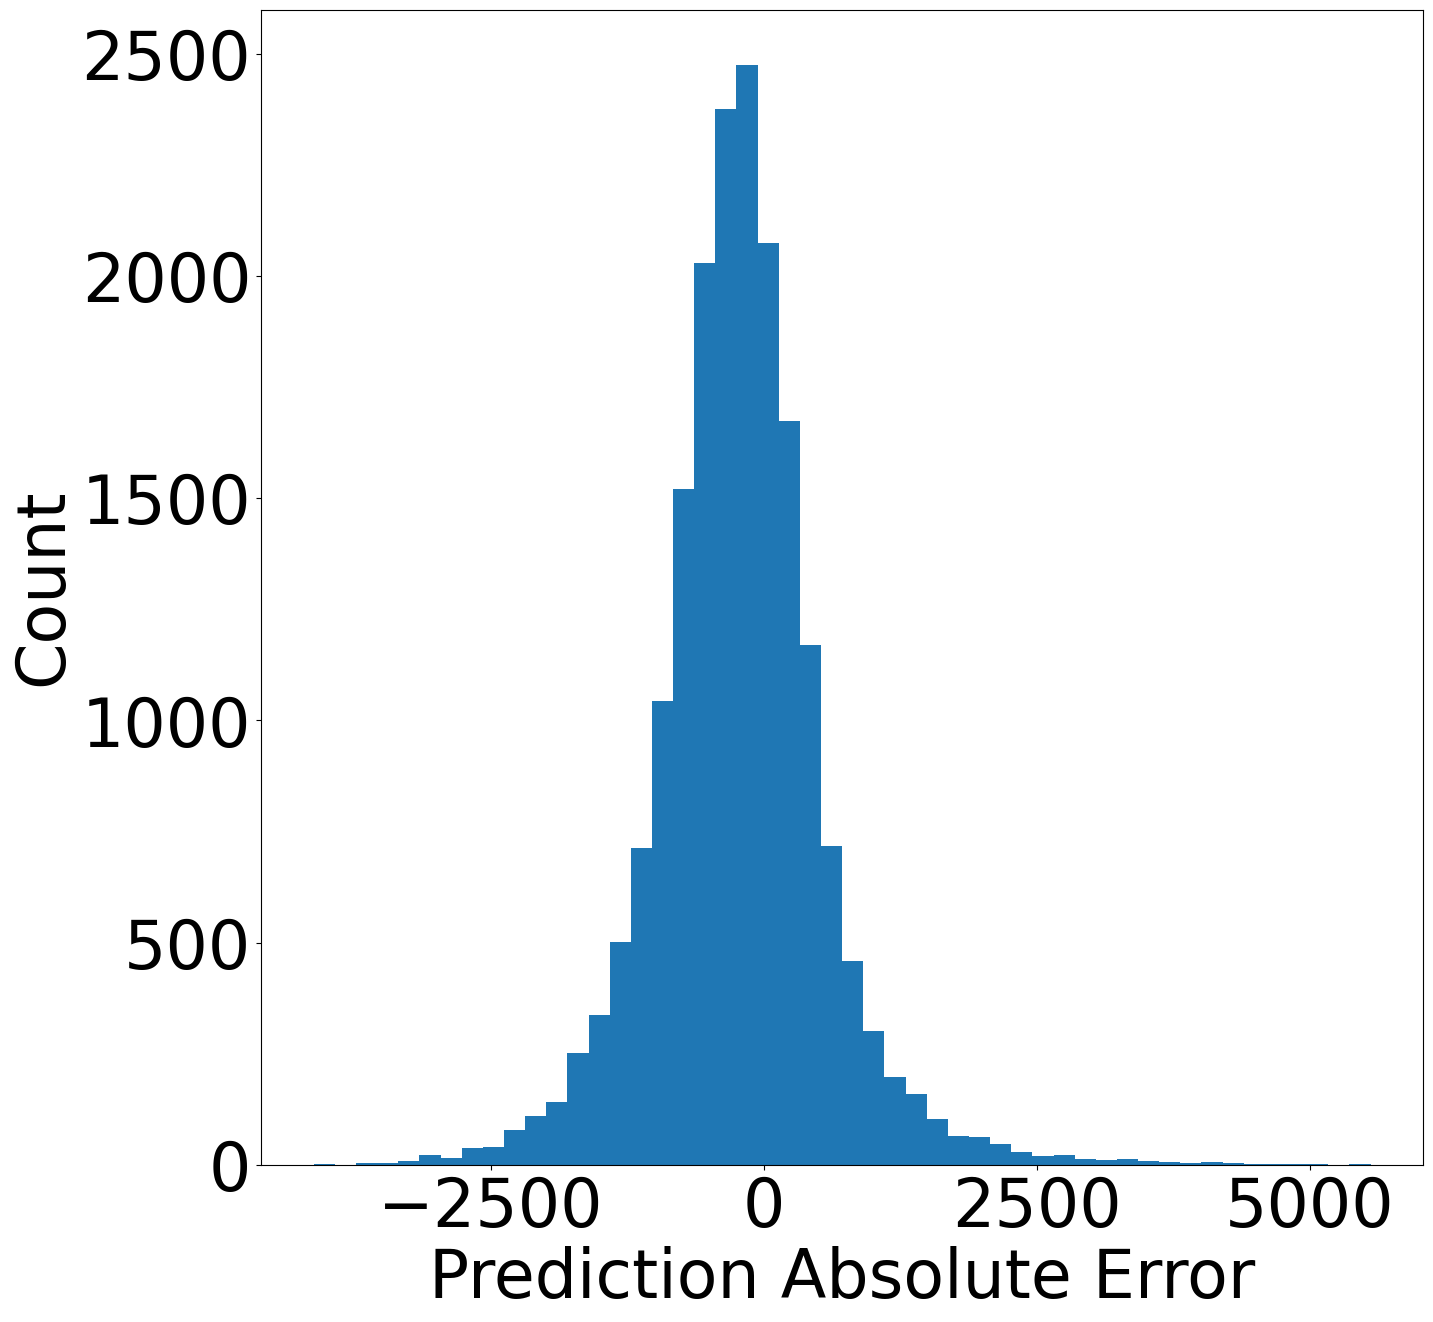

In [20]:
plt.figure(figsize=(15,15))
plt.hist(error, bins = 50)
plt.xlabel("Prediction Absolute Error")
_ = plt.ylabel("Count")

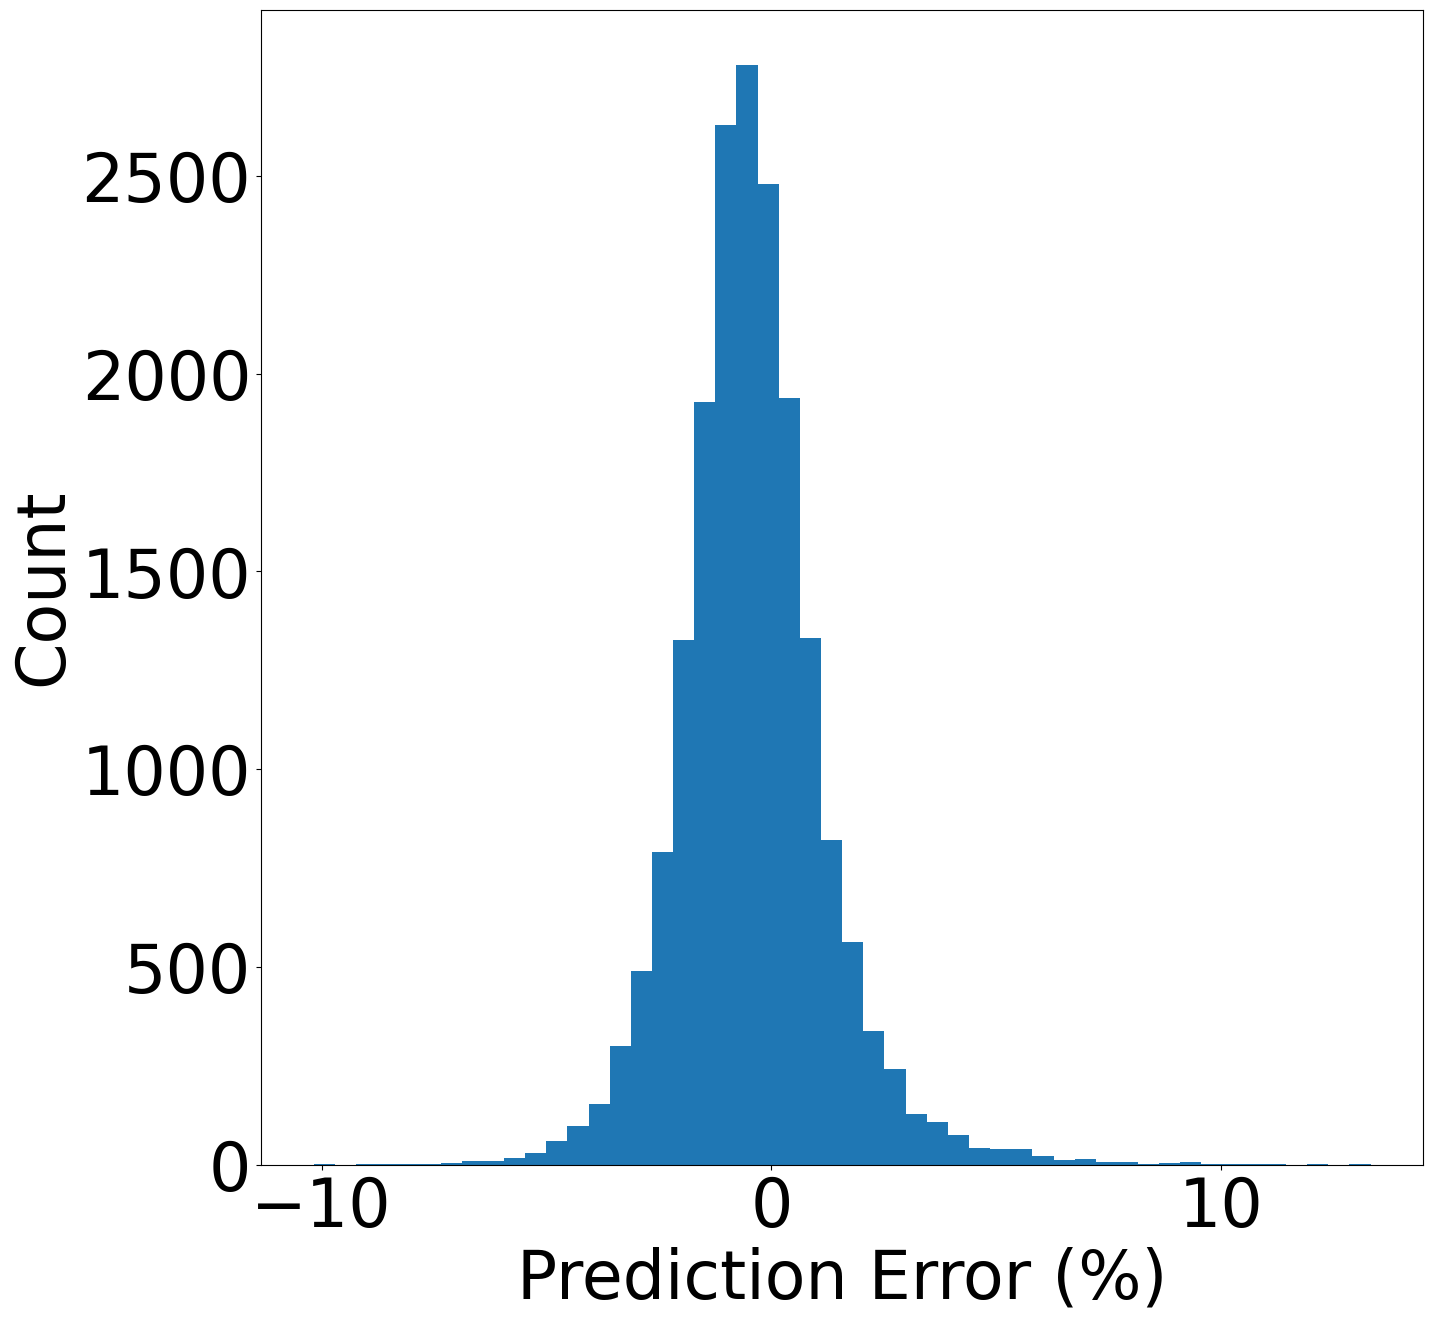

In [21]:
plt.figure(figsize=(15,15))
plt.hist(rerror, bins = 50)
plt.xlabel("Prediction Error (%)")
_ = plt.ylabel("Count")

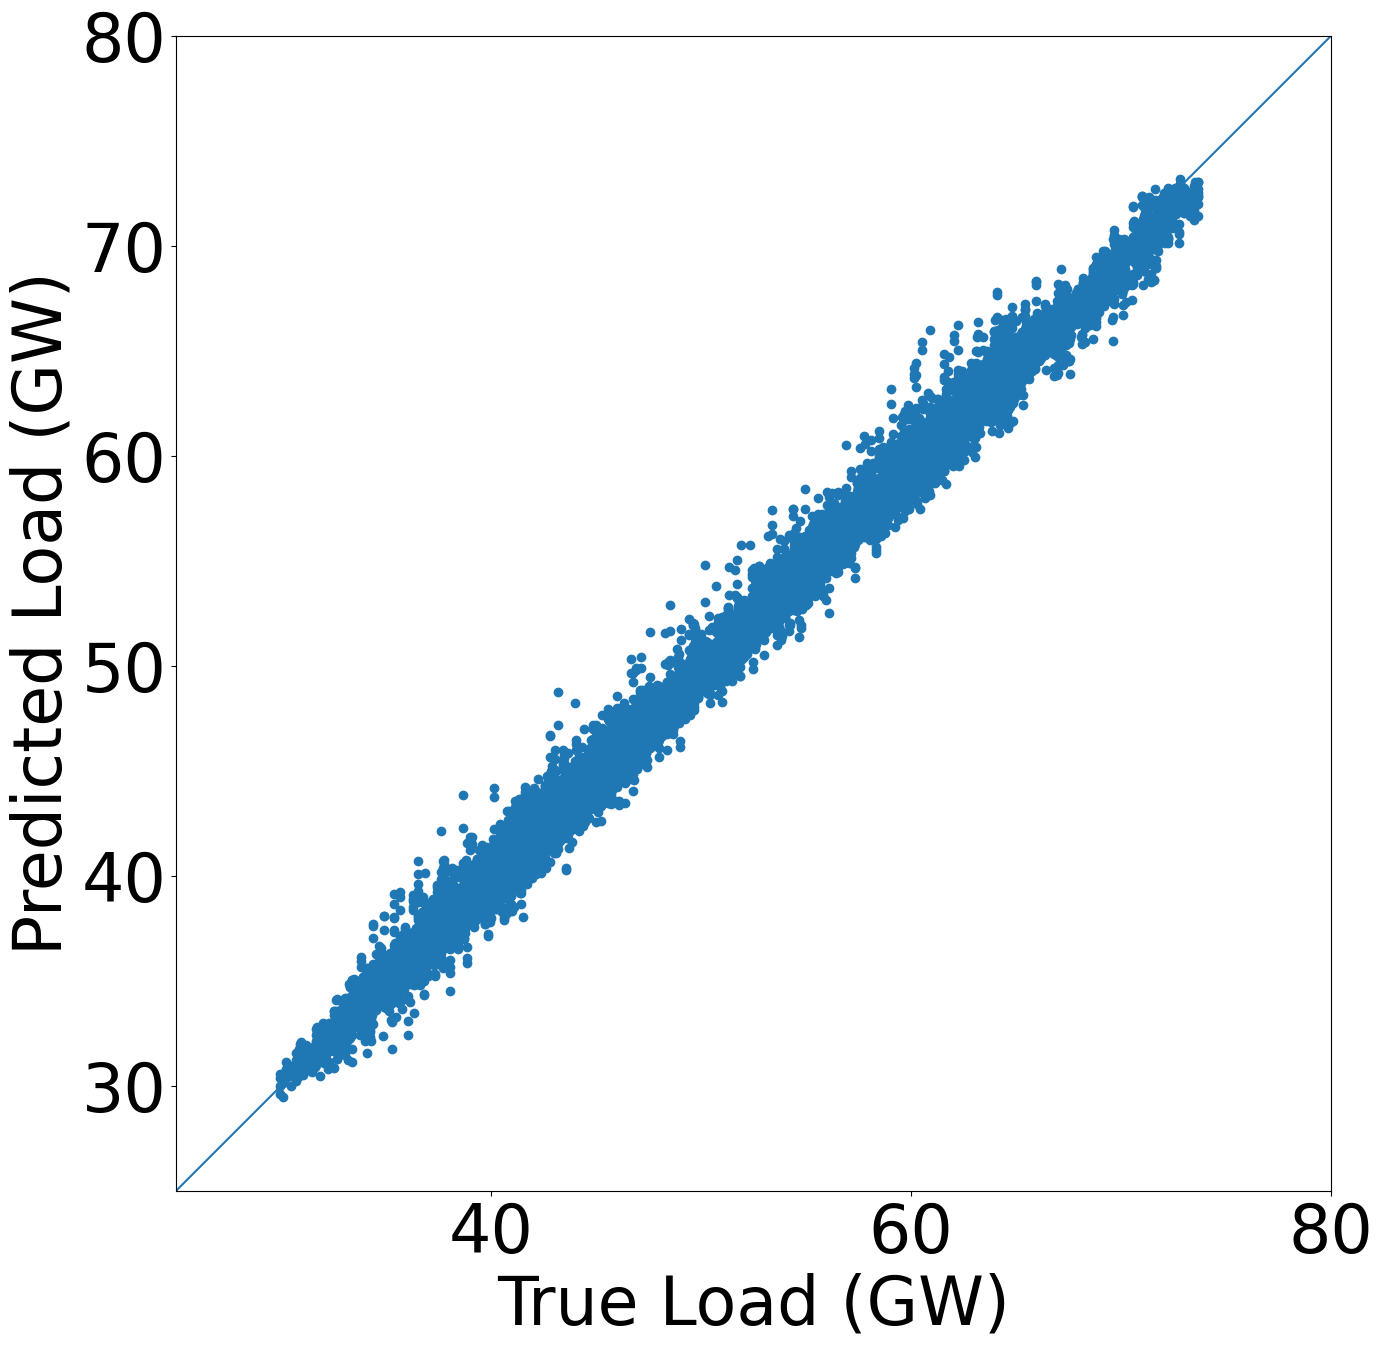

In [19]:
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels['actual']/1000, predictions/1000)
plt.xlabel('True Load (GW)')
plt.ylabel('Predicted Load (GW)')
lims = [25, 80]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [23]:
end = datetime.datetime.now()
print('total time:', end-start)

total time: 9:24:30.344633


In [25]:
from joblib import dump, load
dump(models, 'SVM_models_2.0.joblib') 

['SVM_models_2.0.joblib']

In [1]:
from joblib import load
models = load('SVM_models_2.0.joblib')

In [11]:
test_predictions = [model.predict(X_test) for model in models]
op_list= [e for s in zip(*test_predictions) for e in s]   #predicted list
ip_list = [e for y in Y_test for e in y]    #actual list

In [15]:
test_labels = pd.DataFrame({'actual':ip_list})
predictions = pd.DataFrame({'predict':op_list})
test_labels['actual'] = ct.named_transformers_['y'].inverse_transform(test_labels)
predictions['predict'] = ct.named_transformers_['y'].inverse_transform(predictions)

error = predictions['predict'] - test_labels['actual']
rerror = 100*(predictions['predict'] - test_labels['actual'])/test_labels['actual']

print('Mean of error in test data:', mean(error))
print('Mean of absolute error in test data:', mean(abs(error)))
print('Root of mean of squared error in test data:', mean(error**2)**0.5)
print('Standard deviation of error in test data:', stdev(error))
print("=============================================================")
print('MPE (%):', mean(rerror))
print('MAPE (%):', mean(abs(rerror)))
print('RMSPE (%):', mean(rerror**2)**0.5)
print('Deviation of error (%):', stdev(rerror))
print("=============================================================")
print('Mean of test data:', mean(test_labels['actual']))
print('Standard deviation of test data:', stdev(test_labels['actual']))
print("Coefficient of determination:",r2_score(test_labels['actual'], predictions['predict']))

Mean of error in test data: -228.71353057775661
Mean of absolute error in test data: 599.0951168604886
Root of mean of squared error in test data: 812.3604384928968
Standard deviation of error in test data: 779.5202336861265
MPE (%): -0.42433583954359594
MAPE (%): 1.2597129908899618
RMSPE (%): 1.6924304172704252
Deviation of error (%): 1.63841448511095
Mean of test data: 47586.94378734902
Standard deviation of test data: 10122.94285891266
Coefficient of determination: 0.9935596870942417


In [16]:
np.save('predictions2.0', np.array(predictions['predict']))